<a href="https://colab.research.google.com/github/inigmat/exupery/blob/main/Schedule_CPLEX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CPLEX Installation in Goolge Colab

Modified 'Chapter 5. Using cumulative functions in the house building problem' from https://ibmdecisionoptimization.github.io/tutorials/html/Scheduling_Tutorial.html

In [16]:
import sys

try:
    import docplex.mp
except:
    if hasattr(sys, 'real_prefix'):
        !pip install docplex
    else:
        !pip install --user docplex

try:
    import cplex
except:
    if hasattr(sys, 'real_prefix'):
        !pip install cplex
    else:
        !pip install --user cplex
        exit()

## Problem to be solved

The problem consists of assigning start dates to a set of tasks in such a way that the schedule satisfies temporal constraints and minimizes a criterion. The criterion
for this problem is to minimize the overall completion date.

For each task type in the house building project, the following table shows the duration of the task in days along with the tasks that must be finished before the task can start. Each task requires any one of the three workers. A worker can only work on one task at a time; each task, once started, may not be interrupted.

House construction tasks:

| Task      | Duration | Preceding tasks      |
|-----------|----------|----------------------|
| masonry   | 35       |                      |
| carpentry | 15       |  masonry             |
| plumbing  | 40       |  masonry             |
| ceiling   | 15       |  masonry             |
| roofingv  |  5       |  carpentry           |
| painting  | 10       |  ceiling             |
| windows   |  5       |  roofing             |
| facade    | 10       |  roofing, plumbing   |
| garden    |  5       | roofing, plumbing    |
| moving    |  5       |  windows, facade, garden,painting |

There is an earliest starting date for each of the five houses that must be built.

| House | Earliest starting date |
|---|----|
| 0 | 31 |
| 1 | 0  |
| 2 | 90 |
| 3 | 120|
| 4 | 90 |

Solving the problem consists of determining starting dates for the tasks such that
the overall completion date is minimized.

## Prepare data
In the related data file, the data provided includes the number of houses (NbHouses), the number of workers (NbWorkers), the names of the tasks (TaskNames), the sizes of the tasks (Duration), the precedence relations (Precedences), and the earliest start dates of the houses (ReleaseDate).

As each house has an earliest starting date, the task interval variables are declared to have a start date no earlier than that release date of the associated house. The ending dates of the tasks are not constrained, so the upper value of the range for the variables is maxint.

In [17]:
NbWorkers = 3
NbHouses  = 5

TaskNames = ("masonry","carpentry","plumbing",
             "ceiling","roofing","painting",
             "windows","facade","garden","moving")

Duration =  [35, 15, 40, 15, 5, 10, 5, 10, 5, 5]

ReleaseDate = [31, 0, 90, 120, 90]

In [18]:
Houses = range(NbHouses)

In [19]:
Precedences = [("masonry", "carpentry"), ("masonry", "plumbing"), ("masonry", "ceiling"),
               ("carpentry", "roofing"), ("ceiling", "painting"), ("roofing", "windows"),
               ("roofing", "facade"), ("plumbing", "facade"), ("roofing", "garden"),
               ("plumbing", "garden"), ("windows", "moving"), ("facade", "moving"),
               ("garden", "moving"), ("painting", "moving")]

## Create the interval variables

In [20]:
from docplex.cp.model import *

In [21]:
mdl4 = CpoModel()

In [22]:
itvs = {}
for h in Houses:
    for i,t in enumerate(TaskNames):
        itvs[h,t] = mdl4.interval_var(start = [ReleaseDate[h], INTERVAL_MAX], size=Duration[i])

As the workers are equivalent in this problem, it is better to represent them as one pool of workers instead of as individual workers with no overlap constraints as was done in the earlier examples.
The expression representing usage of this pool of workers can be modified by the interval variables that require a worker.

To model both the limited number of workers and the limited budget, we need to represent the sum of the individual contributions associated with the interval variables.
In the case of the cash budget, some tasks consume some of the budget at the start.
In the case of the workers, a task requires the worker only for the duration of the task.


## Declare the worker usage function

In [23]:
workers_usage = step_at(0, 0)
for h in Houses:
    for t in TaskNames:
        workers_usage += mdl4.pulse(itvs[h,t],1)

## Add the temporal constraints

In [24]:
for h in Houses:
    for p in Precedences:
        mdl4.add( mdl4.end_before_start(itvs[h,p[0]], itvs[h,p[1]]) )

## Add the worker usage constraint

In [25]:
mdl4.add( workers_usage <= NbWorkers )

## Add the objective

In [26]:
mdl4.add(
    mdl4.minimize(
        mdl4.max( mdl4.end_of(itvs[h,"moving"]) for h in Houses)
    )
)

## Solve the model

In [27]:
# Solve the model
msol4 = mdl4.solve(FailLimit=30000)
print("done")

<ipython-input-25-219fc9d49246>:1(stream:134:1): Warning: Cumulative expression 'stepAt': height is zero, expression is zero everywhere.
                                                            stepAt(0, 0)
 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Minimization problem - 50 variables, 71 constraints
 ! FailLimit            = 30000
 ! Initial process time : 0.00s (0.00s extraction + 0.00s propagation)
 !  . Log search space  : 282.2 (before), 282.2 (after)
 !  . Memory usage      : 586.4 kB (before), 586.4 kB (after)
 ! Using parallel search with 2 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0         50                 -
 + New bound is 210
 *           271      103  0.21s        1      (gap is 22.51%)
 *           270      203  0.21s        1      (gap is 22.22%)
 *           265      834  0.21s        1      (

In [28]:
print("Project duration in days:" + str( msol4.get_objective_values()[0] ))

Project duration in days:265


## Plotting the results

In [29]:
import docplex.cp.utils_visu as visu
import matplotlib.pyplot as plt
%matplotlib inline
#Change the plot size
from pylab import rcParams
rcParams['figure.figsize'] = 15, 3

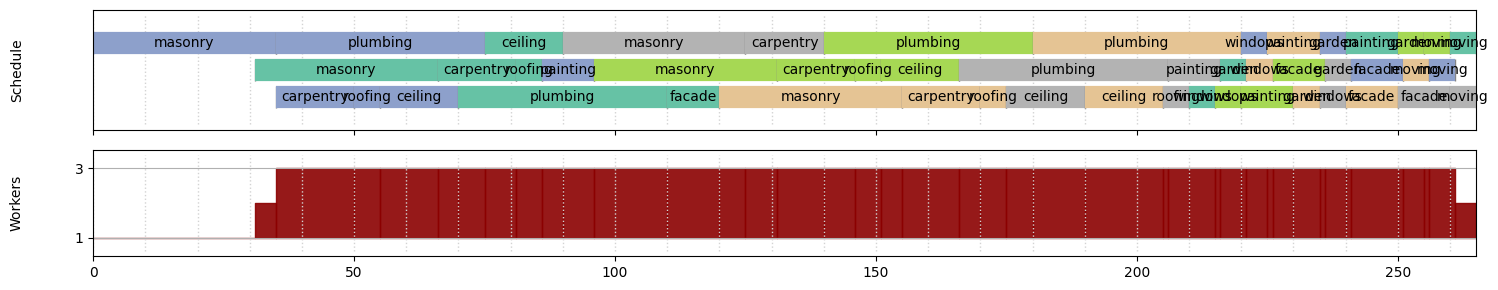

In [30]:
workersF = CpoStepFunction()
for h in Houses:
    for i,t in enumerate(TaskNames):
        itv = msol4.get_var_solution(itvs[h,t])
        workersF.add_value(itv.get_start(), itv.get_end(), 1)

visu.timeline('Solution SchedCumul')
visu.panel(name="Schedule")
for h in Houses:
    for i,t in enumerate(TaskNames):
        visu.interval(msol4.get_var_solution(itvs[h,t]), h, t)
visu.panel(name="Workers")
visu.function(segments=workersF, style='area')
visu.show()